# Neural Style Transfer Project

## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg19
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, save_img
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm 
import os
from datetime import datetime

In [2]:
# Path of image we want to transform
content_image_path = './data/content_images/peacock.jpg'

# Path to the style image
style_image_path = './data/style_images/flowers.jpeg'

# Dimensions of the generated picture
width , height = load_img(content_image_path).size
img_height = 224
img_width = int(width*img_height/height)

#Prefix for saving generated images
result_prefix = "generated_image"

#Defining the path for 'Result Images' Folder
results_folder= os.path.join('./Result Images', datetime.now().strftime('%d%m%Y_%H%M%S'))

#Create folder if it doesn't exist
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

## Functions

### Load and Preprocess Image Function

In [3]:
def load_and_preprocess_image(image_path):
    #Load image, resize, convert to array, preprocess
    img = load_img(image_path, target_size=(img_height,img_width))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)

### Deprocessing Image Function

In [4]:
def deprocessing_image(x):
    if len(x.shape) ==4:
        x = np.squeeze(x,0)
    x= x.copy()
    # Removing zero center by mean pixel
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    
#BGR to RGB
    x = x[:,:,::-1]
    x = np.clip(x,0,255).astype('uint8')
    return x

### Display Image Function

In [5]:
def display_image(image, title=None):
  if len(image.shape) == 4:
    image = np.squeeze(image, axis=0)
    image = deprocessing_image(image)
  plt.imshow(image)
  if title:
    plt.title(title)

## Load and Display Images

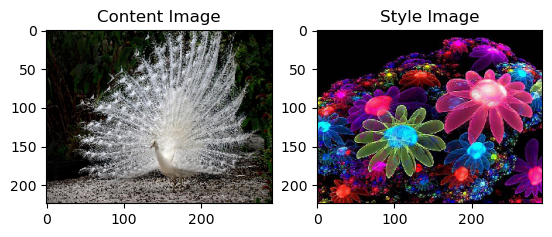

In [6]:
# loading content and style images
content_image = load_and_preprocess_image(content_image_path)
style_image = load_and_preprocess_image(style_image_path)

# displaying content and style images
plt.subplot(1, 2, 1)
display_image(content_image, 'Content Image')

plt.subplot(1, 2, 2)
display_image(style_image, 'Style Image')

## Neural Style Transfer Setup

### Defining VGG19

In [7]:
# The model will be loaded with pre-trained ImageNet weights
def get_model():
    model = vgg19.VGG19( include_top=False,
    weights='imagenet')
    return model

model = get_model()
print('Model loaded')

Model loaded


In [8]:
for layer in model.layers:
  print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Extracting features from VGG19 Layers

In [9]:
outputs_dict = {layer.name: layer.output for layer in model.layers}

# Set up a model that returns the activation values for every layer in VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.input, outputs=outputs_dict)

# Name of layer used for content loss
content_layer = ['block5_conv2']

# Name of layer used for style loss
style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

### Weights for Loss Calculation

In [10]:
total_variation_weight = 1e-4
style_weight = 5
content_weight = 0.025

## Loss Functions

In [11]:
def compute_loss(combination_image, content_image, style_image):
     input_tensor = tf.concat([content_image, style_image, combination_image], axis=0)
     features = feature_extractor(input_tensor)
    
# Defining the loss by adding all components to a 'loss' variable
     loss = tf.zeros(shape=(),dtype=tf.float32)

# Add content loss
     layer_features = features[content_layer[0]]
     content_image_features = tf.cast(layer_features[0, :, :, :],tf.float32)
     combination_features = tf.cast(layer_features[2, :, :, :],tf.float32)
     loss = loss + content_weight * content_loss(content_image_features, combination_features )

        # Add style loss
     for layer_name in style_layers:
         layer_features = features[layer_name]
         style_reference_features = tf.cast(layer_features[1, :, :, :],tf.float32)
         combination_features = tf.cast(layer_features[2, :, :, :],tf.float32)
         sl = style_loss(style_reference_features, combination_features)
         loss += (style_weight / len(style_layers)) * sl


        # Add total variation loss
         loss += total_variation_weight * total_variation_loss(tf.cast(combination_image,tf.float32))
     return loss

 ### Content Loss Function

In [12]:
def content_loss(content, combination):
    return tf.reduce_mean(tf.square(combination - content))

### Gram Matrix Function for Style Loss

In [13]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

### Style Loss Function

In [14]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return tf.reduce_mean(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

### Total Variation Loss Function

In [15]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

### Loss and Gradient Calculation Function

In [16]:
@tf.function
def loss_and_gradient(combination_image, content_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, content_image, style_image)
    gradient = tape.gradient(loss, combination_image)
    return loss, gradient

## Model Training

### Enabling Mixed Precision Training

In [17]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

### Optimizer and Training Loop

 16%|█████████████▏                                                                   | 49/300 [04:29<27:20,  6.54s/it]

Iteration 50: loss=704371.81


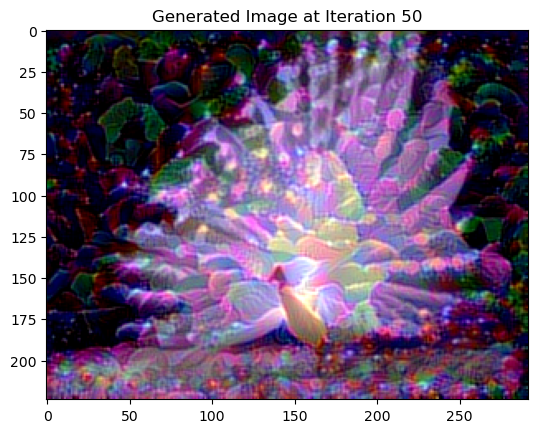

 33%|██████████████████████████▋                                                      | 99/300 [09:05<16:11,  4.83s/it]

Iteration 100: loss=552212.00


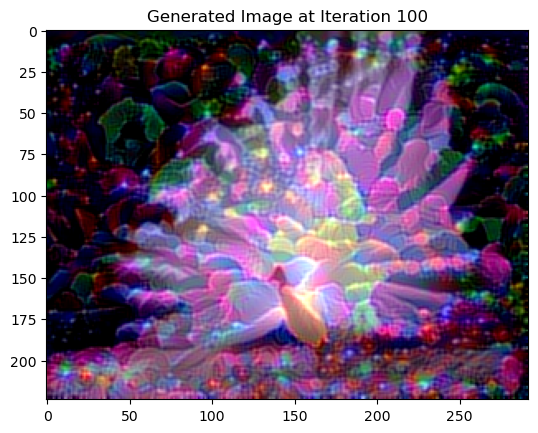

 50%|███████████████████████████████████████▋                                        | 149/300 [13:10<11:55,  4.74s/it]

Iteration 150: loss=504867.12


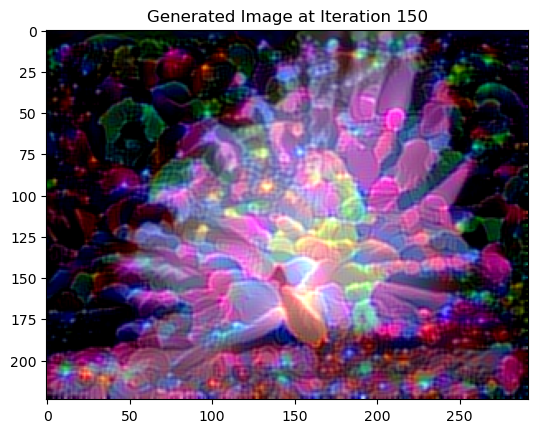

 66%|█████████████████████████████████████████████████████                           | 199/300 [17:15<07:38,  4.54s/it]

Iteration 200: loss=477049.25


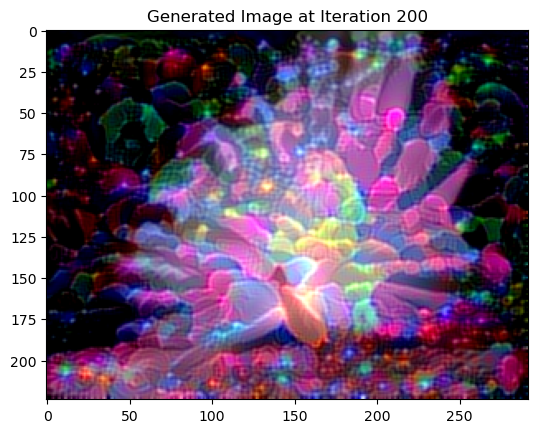

 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [21:48<04:38,  5.47s/it]

Iteration 250: loss=458695.91


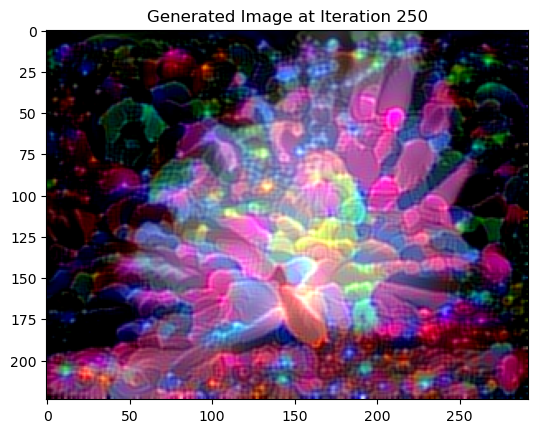

100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [26:20<00:04,  4.97s/it]

Iteration 300: loss=445846.94


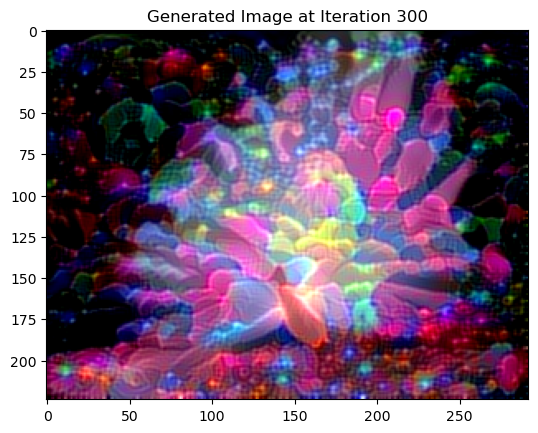

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [26:26<00:00,  5.29s/it]


In [18]:
# Optimizer Definition
optimizer = tf.keras.optimizers.Adam(learning_rate=5.)


content_image = load_and_preprocess_image(content_image_path)
style_image = load_and_preprocess_image(style_image_path)
combination_image = tf.Variable(tf.convert_to_tensor(content_image, dtype= tf.float32))

# Training Loop
iterations = 300
for i in tqdm(range(1, iterations + 1)):
    loss, gradient = loss_and_gradient(combination_image, content_image, style_image)
    optimizer.apply_gradients([(gradient, combination_image)])

    # saving image after every 50 steps
    if i % 50 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        
        img = deprocessing_image(combination_image)
        fname = result_prefix + "_at_iteration_%d.png" % i
        save_img(os.path.join(results_folder,fname), img)
        plt.imshow(img)
        plt.title(f"Generated Image at Iteration {i}")
        plt.show()

## Content, Style and Combined Image

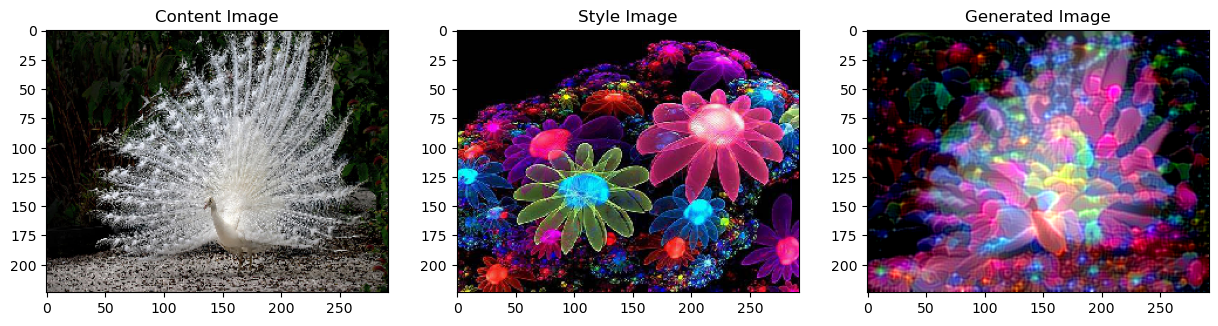

In [19]:
content_image_deprocessed = deprocessing_image(content_image)
style_image_deprocessed = deprocessing_image(style_image)
combined_image_deprocessed = deprocessing_image(combination_image)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
display_image(content_image_deprocessed, 'Content Image')

plt.subplot(1, 3, 2)
display_image(style_image_deprocessed, 'Style Image')

plt.subplot(1,3,3)
plt.imshow(combined_image_deprocessed)
plt.title('Generated Image')
plt.show()